# ROC curves

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import pandas as pd
import upath
import extras

In [3]:
import logging

# set up handler
handler = logging.StreamHandler()
formatter = logging.Formatter("%(asctime)s %(levelname)s %(message)s")
handler.setFormatter(formatter)
logging.getLogger().handlers = [handler]

# set up logger
logger = logging.getLogger(__name__)

# set levels
logging.getLogger().setLevel("INFO")
logger.setLevel("DEBUG")
logging.getLogger("extras").setLevel("INFO")

In [4]:
path_root = upath.UPath("gs://liulab/differential_composition_and_expression/20230317_06h00m45s")
# print(extras.get_parquet_paths(path_root))
# !gsutil ls "{path_root}/*"

In [5]:
df_gene_stats = extras.load_gene_stats(path_root)

In [6]:
# # limit to rows where "origin" index is "malignant_cibersortx"
# df_gene_stats = df_gene_stats.loc[
#     df_gene_stats.index.get_level_values("origin") == "malignant_cibersortx"
# ]

## ROC (TPR, FPR)

In [7]:
df = df_gene_stats.xs("malignant_cibersortx", level="origin", drop_level=False)
print(df.groupby(["origin", "run_id"]).size())
df_roc_curves, df_roc_auc_scores = extras.calculate_roc(df)

run_id
00    899528
01    562205
dtype: int64


In [8]:
import seaborn as sns

cm = sns.light_palette("green", as_cmap=True)


def mean_and_stddev(series: pd.Series):
    mean = series.mean()
    stddev = series.std()
    return f"{mean:4.2f}±{stddev:4.2f}"

In [9]:
(
    df_roc_auc_scores.groupby(["malignant_means", "log2_fc"])
    # .agg(func=mean_and_stddev)
    .mean().unstack("log2_fc")
).style.background_gradient(cmap=cm)

log2_fc,-1.50,-1.00,-0.50,0.00,0.50,1.00,1.50
malignant_means,,,,,,,
"0.55,0.85",0.959335,0.909197,0.756426,0.551503,0.639130,0.758092,0.809715
"0.65,0.75",0.941922,0.882623,0.773131,0.574636,0.727310,0.821468,0.893152
"0.7,0.72",0.922418,0.849642,0.716220,0.582969,0.757783,0.886796,0.930010
"0.71,0.71",0.917686,0.854019,0.717507,0.590557,0.748067,0.837277,0.928381
"None,None",0.948003,0.884425,0.807243,0.558231,0.795656,0.848103,0.926093
"0.72,0.7",0.914455,0.910197,0.694021,0.600162,0.767542,0.880593,0.938431
"0.75,0.65",0.882981,0.770684,0.676822,0.607900,0.772047,0.871002,0.920975
"0.85,0.55",0.631710,0.725310,0.631765,0.538720,0.743874,0.800233,0.876601


In [10]:
(
    df_roc_auc_scores.groupby(["malignant_means", "log2_fc"])
    .agg(func=mean_and_stddev)
    .unstack("log2_fc")
).style.background_gradient(cmap=cm)

log2_fc,-1.50,-1.00,-0.50,0.00,0.50,1.00,1.50
malignant_means,,,,,,,
"0.55,0.85",0.96±0.02,0.91±0.02,0.76±0.00,0.55±0.03,0.64±0.08,0.76±0.04,0.81±0.08
"0.65,0.75",0.94±0.02,0.88±0.02,0.77±0.00,0.57±0.03,0.73±0.02,0.82±0.02,0.89±0.02
"0.7,0.72",0.92±0.02,0.85±0.06,0.72±0.01,0.58±0.02,0.76±0.02,0.89±0.01,0.93±0.02
"0.71,0.71",0.92±0.03,0.85±0.01,0.72±0.03,0.59±0.00,0.75±0.01,0.84±0.04,0.93±0.01
"None,None",0.95±0.01,0.88±0.02,0.81±0.04,0.56±0.00,0.80±0.08,0.85±0.00,0.93±0.03
"0.72,0.7",0.91± nan,0.91± nan,0.69± nan,0.60± nan,0.77± nan,0.88± nan,0.94± nan
"0.75,0.65",0.88± nan,0.77± nan,0.68± nan,0.61± nan,0.77± nan,0.87± nan,0.92± nan
"0.85,0.55",0.63± nan,0.73± nan,0.63± nan,0.54± nan,0.74± nan,0.80± nan,0.88± nan


In [11]:
fig = extras.plot_roc(df_roc_curves)

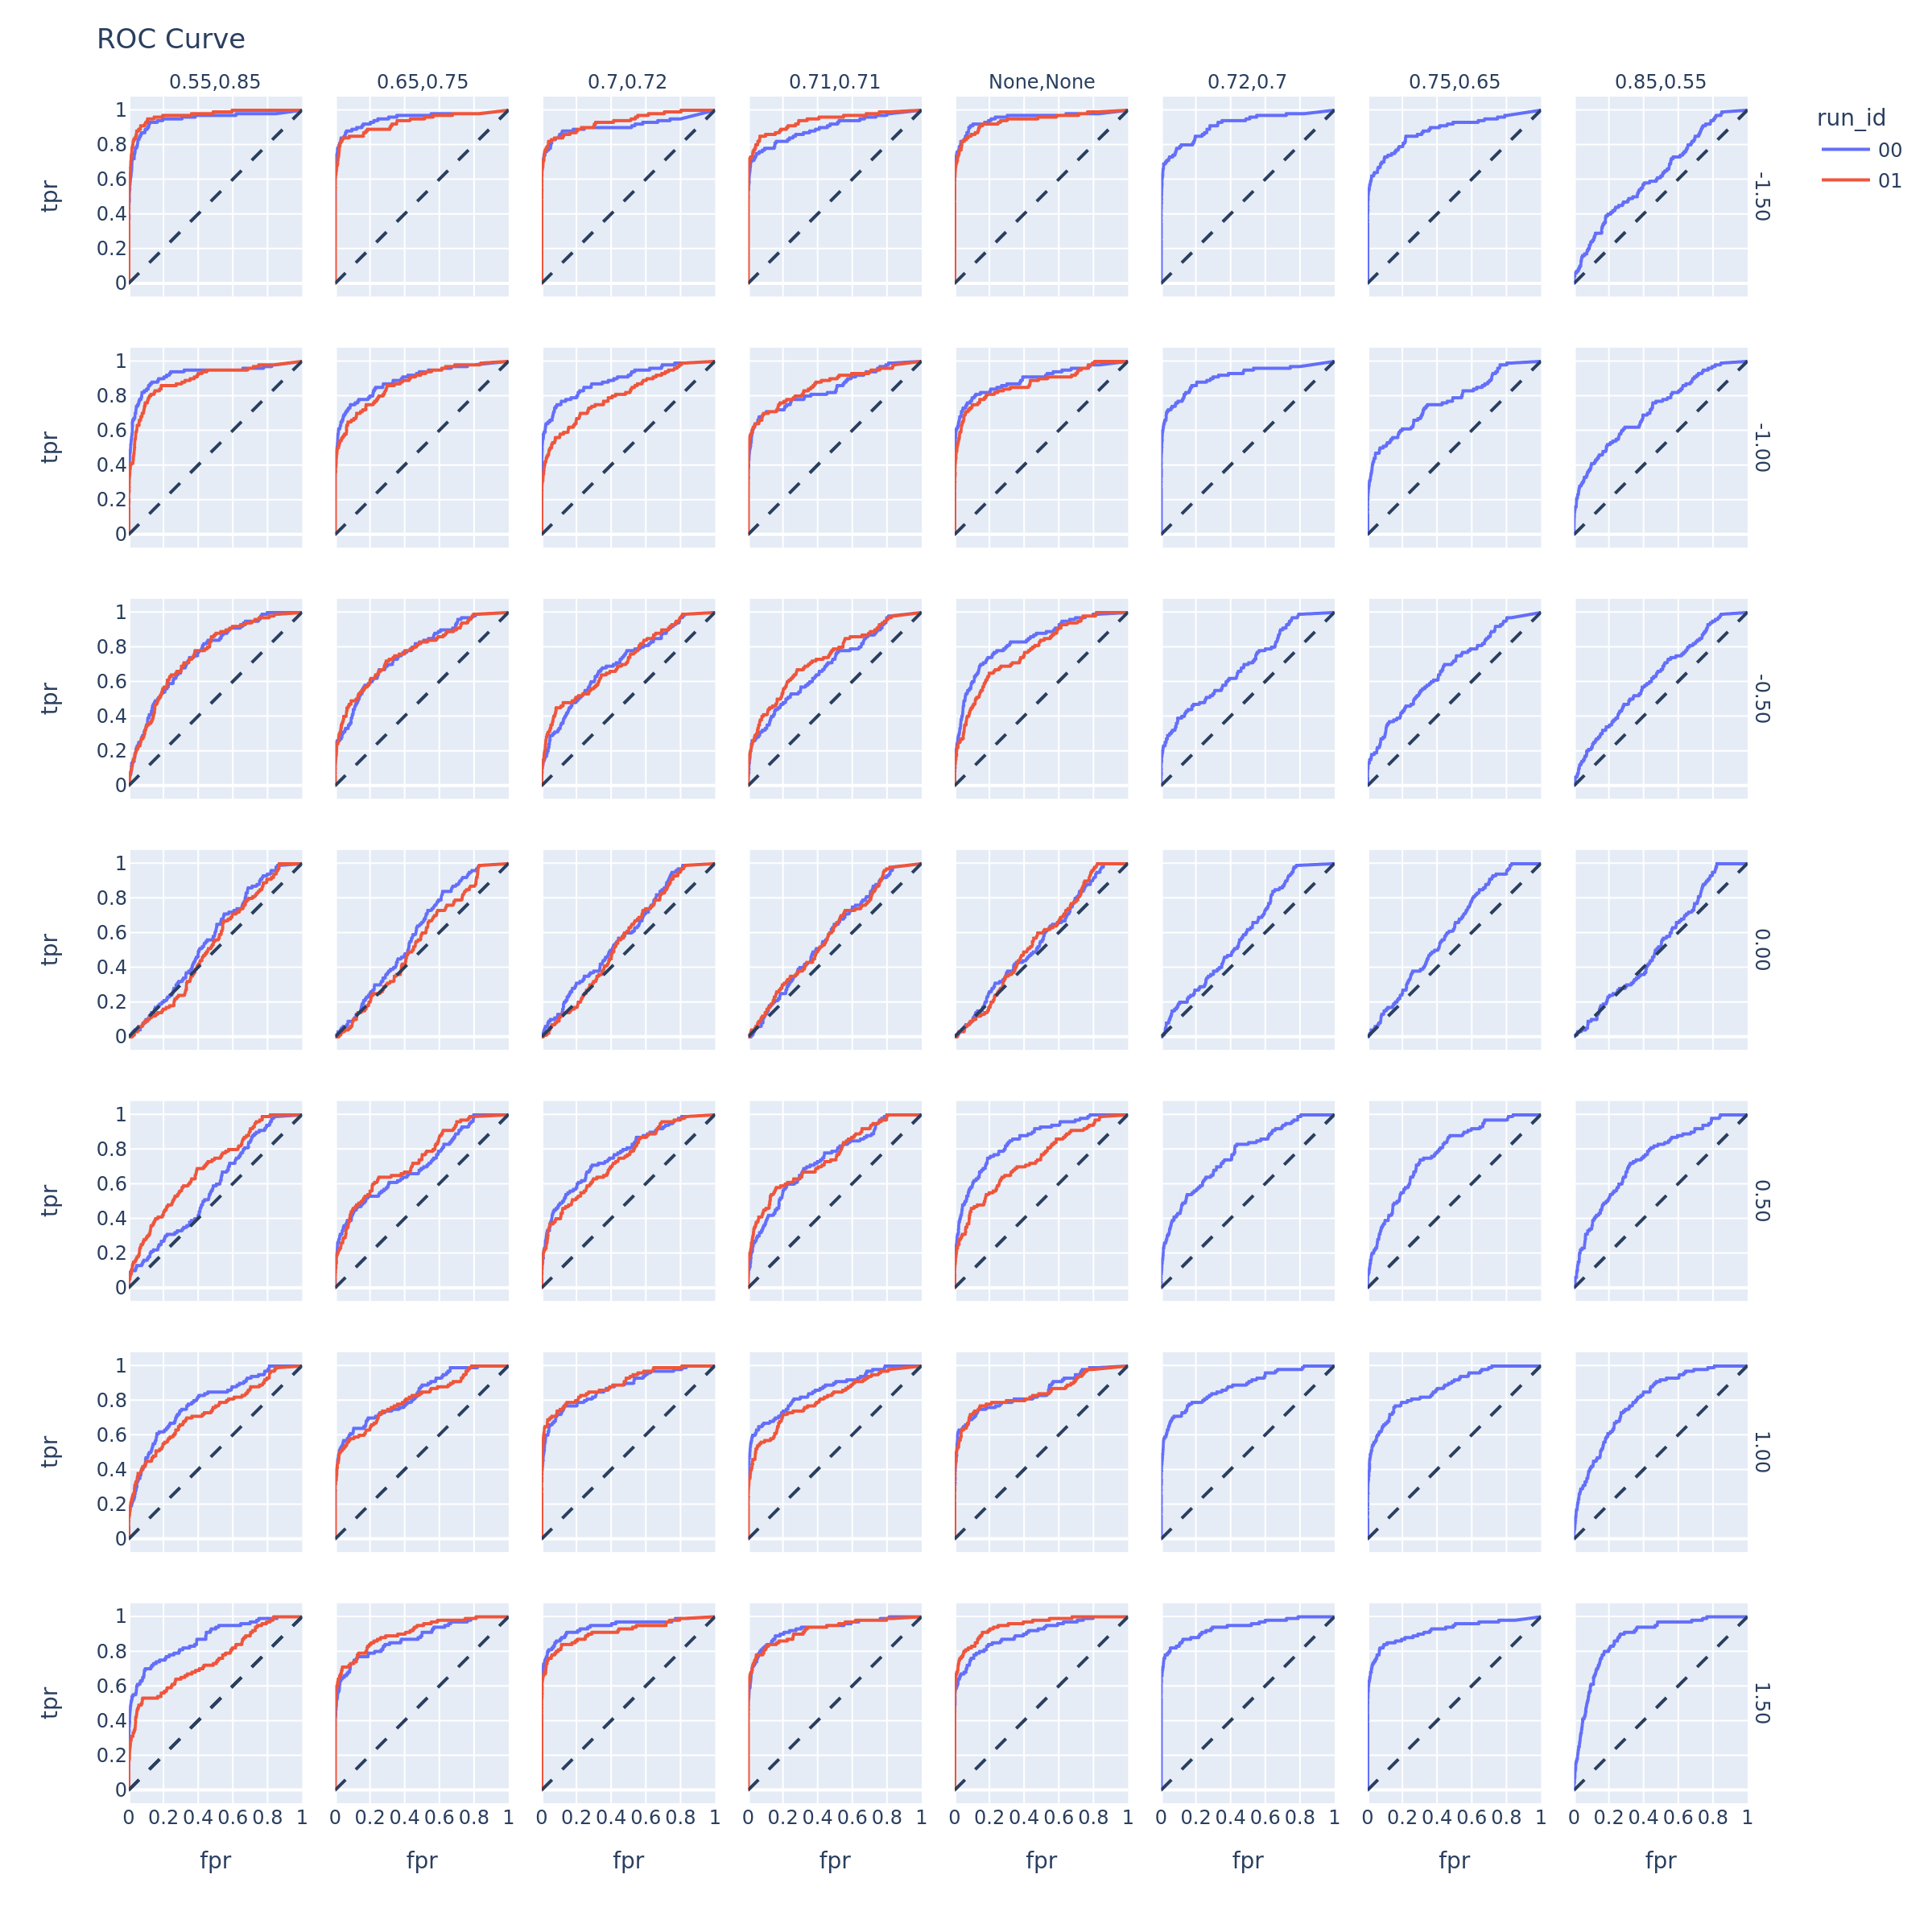

In [12]:
fig.update_layout(width=1200, height=1200)
fig.show(renderer="png", scale=2)